In [86]:
import numpy as np
import pandas as pd
from math import ceil
import similaritymeasures
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import find_peaks
from matplotlib.ticker import PercentFormatter
from geneticalgorithm import geneticalgorithm as ga
import importlib.util, re, os, shutil, PyQt5, argparse

import matplotlib
matplotlib.use('qt5agg')
import addcopyfighandler
# %matplotlib widget
%matplotlib inline

# parse data from log

In [87]:
string2time = lambda date_str: datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S.%f")
def parse_line(line):
    pattern_line = re.compile(r'([\w]{1,30})(\[[\w]{1,10}\]){0,1}: ?(-?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)')
    line_data = re.findall(pattern_line, line)
    line_data_dict = {}
    for item_data in line_data:
        if len(item_data) == 2:
            key, value = item_data[0], item_data[1]
        else:
            key, value = item_data[0] + item_data[1], item_data[2]
        line_data_dict[key] = float(value)
    return [(key, float(value)) for key, value in line_data_dict.items()]

def parse_time(line):
    pattern_time = re.compile(r"(\d{2}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}.\d{3})")
    time_data = re.findall(pattern_time, line)
    return "20" + time_data[0]

def parse_data(log_file, pattern):
    log_data = []
    log_time = []
    var_num = pattern.count(':')
    match_num_prev = None
    if pattern.count(':') == 1:
        line_parse = lambda line: parse_line(line.split("$$")[1])
        pattern = pattern.split(':')[0]
    else:
        line_parse = lambda line: parse_line(line)
        pattern = pattern.split(':')[0]
    with open(log_file) as log:
        for line in log:
            if pattern not in line:
                continue
            else:
                try:
                    match_result = line_parse(line)
                    if match_num_prev is None or (len(match_result) == match_num_prev):
                        key_value_list = match_result
                        match_num_prev = len(match_result)
                        key = [i[0] for i in key_value_list]
                        value = [i[1] for i in key_value_list]
                        start_index = key.index(pattern)
                        log_data.append(value[start_index:start_index+var_num])
                        log_time.append(parse_time(line))
                    else:
                        print("#1 " + line, end='')
                        pass
                except:
                    pass
    if len(log_time) == 0:
        log_time = np.arange(len(log_data))
    return np.array(log_data), log_time, key[start_index:]


In [88]:
input_file = "/ssd/open_source/torcs/torcs-1.3.7/scr_client/TorcsOutput.log"
pattern = "targetSpeed: 150, currentSpeed: 149.367, acc: 0.306337"
log_data, log_time, log_key = parse_data(input_file, pattern)
df_log = pd.DataFrame(log_data, columns=log_key)
df_log.insert(0, 'log_time', log_time)

In [89]:
# df_log.head(20)
# df_log.tail(10)
df_log.shape

(9028, 4)

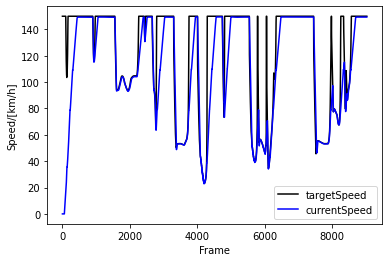

In [90]:
plt.figure()
plt.plot(df_log['targetSpeed'], color = 'k', label = 'targetSpeed')
plt.plot(df_log['currentSpeed'], color = 'b', label = 'currentSpeed')
plt.xlabel('Frame')
plt.ylabel('Speed/[km/h]')
plt.legend()
plt.show()

In [91]:
input_file = "/ssd/open_source/torcs/torcs-1.3.7/scr_client/TorcsOutput.log"
pattern = "vx: -0.00163516, delta: 0.166892, vy: -0.00776939, yaw_rate: -0.0309915, x: 602.857, y: 1167.06, theta: -1.74479, fuel: 93.9999, yaw: 0.0333808"
log_data, log_time, log_key = parse_data(input_file, pattern)
df_log = pd.DataFrame(log_data, columns=log_key)
df_log['delta'] = df_log['delta'] / np.pi * 180
df_log.insert(0, 'log_time', log_time)
df_log.head(10)

,log_time,vx,delta,vy,yaw_rate,x,y,theta,fuel,yaw
0,2025-04-05 15:45:19.303,-0.001635,0.000000,-0.007769,-0.030992,602.857,1167.06,-1.74479,94.0000,0.033381
1,2025-04-05 15:45:19.319,-0.001635,9.562207,-0.007769,-0.030992,602.857,1167.06,-1.74479,94.0000,0.033381
2,2025-04-05 15:45:19.352,-0.001635,9.562207,-0.007769,-0.030992,602.857,1167.06,-1.74479,93.9999,0.033381
3,2025-04-05 15:45:19.368,-0.001635,9.562207,-0.007769,-0.030992,602.857,1167.06,-1.74479,93.9998,0.033381
4,2025-04-05 15:45:19.386,-0.001635,9.562207,-0.007769,-0.030992,602.857,1167.06,-1.74479,93.9997,0.033381
5,2025-04-05 15:45:19.409,-0.001635,9.562207,-0.007769,-0.030992,602.857,1167.06,-1.74479,93.9997,0.033381
6,2025-04-05 15:45:19.418,-0.001635,9.562207,-0.007769,-0.030992,602.857,1167.06,-1.74479,93.9996,0.033381
7,2025-04-05 15:45:19.451,-0.001635,9.562207,-0.007769,-0.030992,602.857,1167.06,-1.74479,93.9995,0.033381
8,2025-04-05 15:45:19.468,-0.001635,9.562207,-0.007769,-0.030992,602.857,1167.06,-1.74479,93.9994,0.033381
9,2025-04-05 15:45:19.486,-0.001635,9.562207,-0.007769,-0.030992,602.857,1167.06,-1.74479,93.9993,0.033381


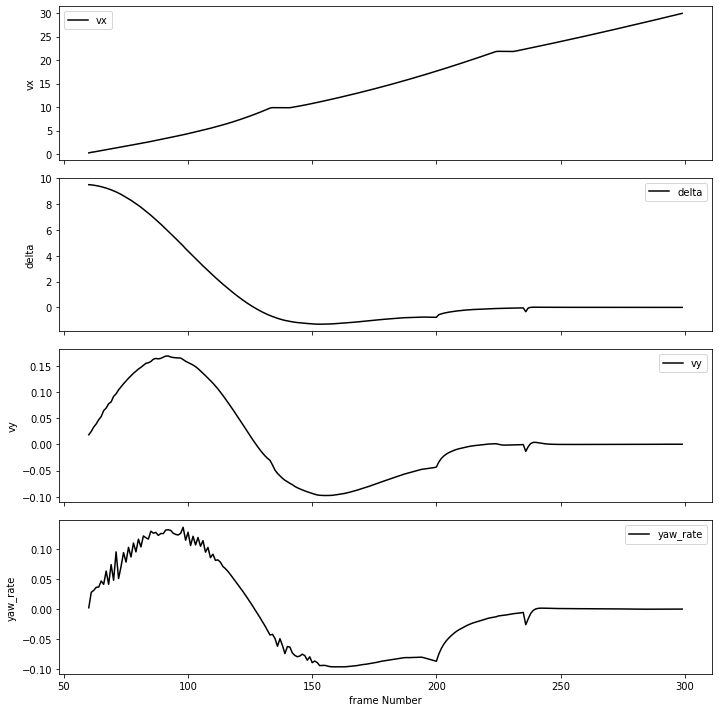

In [92]:
df_log['log_time'] = pd.to_datetime(df_log['log_time'])  # 将时间列转换为datetime类型
df_log['dt'] = df_log['log_time'].diff().dt.total_seconds()
# 将第一个 dt 值设为 0
df_log.loc[0, 'dt'] = 0

start_index = 0
end_index = df_log.shape[0]
start_index = 60
end_index = 300
df_subset = df_log[start_index:end_index]

# 创建四个子图
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

use_time = False
if use_time:
    x_axis = df_subset['log_time']
    x_label = 'log_time'
else:
    x_axis = np.arange(start_index, end_index, 1)
    x_label = 'frame Number'

# 绘制 vx 子图
axs[0].plot(x_axis, df_subset['vx'], label='vx', color = 'k')
axs[0].set_ylabel('vx')
axs[0].legend()

# 绘制 delta 子图
axs[1].plot(x_axis, df_subset['delta'], label='delta', color = 'k')
axs[1].set_ylabel('delta')
axs[1].legend()

# 绘制 vy 子图
axs[2].plot(x_axis, df_subset['vy'], label='vy', color = 'k')
axs[2].set_ylabel('vy')
axs[2].legend()

# 绘制 yaw_rate 子图
axs[3].plot(x_axis, df_subset['yaw_rate'], label='yaw_rate', color = 'k')
axs[3].set_xlabel(x_label)
axs[3].set_ylabel('yaw_rate')
axs[3].legend()

plt.tight_layout()  # 调整子图布局
plt.show()  # 显示图形

In [93]:
df_subset

,log_time,vx,delta,vy,yaw_rate,x,y,theta,fuel,yaw,dt
60,2025-04-05 15:45:20.536,0.267396,9.506287,0.018424,0.001718,602.865,1167.06,0.103402,93.9786,0.034612,0.031
61,2025-04-05 15:45:20.552,0.396231,9.492593,0.024780,0.027488,602.872,1167.06,0.097427,93.9786,0.035025,0.016
62,2025-04-05 15:45:20.569,0.464083,9.464289,0.033159,0.030732,602.880,1167.06,0.106716,93.9786,0.035447,0.017
63,2025-04-05 15:45:20.586,0.561825,9.434724,0.039091,0.035834,602.891,1167.06,0.105447,93.9786,0.036053,0.017
64,2025-04-05 15:45:20.602,0.662306,9.395133,0.047051,0.036249,602.903,1167.06,0.107561,93.9786,0.036711,0.016
...,...,...,...,...,...,...,...,...,...,...,...
295,2025-04-05 15:45:25.535,29.431400,-0.003015,0.000356,-0.000526,677.650,1169.47,0.000933,93.9049,0.000919,0.033
296,2025-04-05 15:45:25.551,29.558600,-0.002936,0.000356,-0.000513,678.299,1169.47,0.000921,93.9042,0.000908,0.016
297,2025-04-05 15:45:25.573,29.686100,-0.002861,0.000356,-0.000501,678.951,1169.47,0.000910,93.9035,0.000897,0.022
298,2025-04-05 15:45:25.588,29.813900,-0.002788,0.000356,-0.000489,679.605,1169.47,0.000899,93.9029,0.000886,0.015


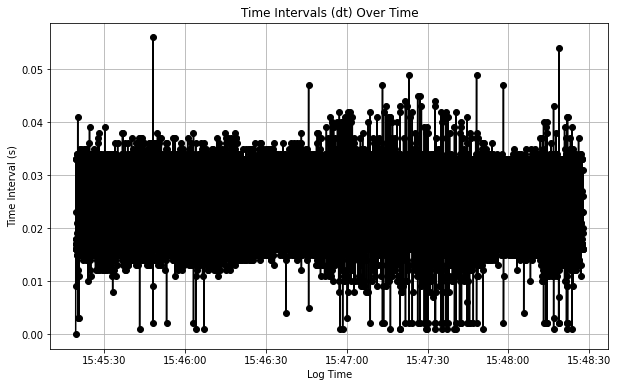

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(df_log['log_time'], df_log['dt'], marker='o', color = 'k')
plt.title('Time Intervals (dt) Over Time')
plt.xlabel('Log Time')
plt.ylabel('Time Interval (s)')
plt.grid(True)
plt.show()

# vehicle model

In [95]:
class VehicleModel:
    def __init__(self, m=1300, lf=1.6154, lr=1.8846, Iz=10000, Cf=3.0054e+04, Cr=2.8930e+04, width=1.8):
        self.m = m
        self.lf = lf
        self.lr = lr
        self.Iz = Iz
        self.Cf = Cf
        self.Cr = Cr
        self.l = self.lf + self.lr
        self.width = width
    
    def dynamics(self, state, t, v, delta):
        # ss-model params
        A = np.array([
            [-(self.Cf + self.Cr) / (self.m * v), -((self.lf * self.Cf - self.lr * self.Cr) / (self.m * v ** 2)) - 1],
            [-(self.lf * self.Cf - self.lr * self.Cr) / self.Iz, -((self.lf ** 2 * self.Cf + self.lr ** 2 * self.Cr) / (self.Iz * v))]
        ])
        B = np.array([self.Cf / (self.m * v), self.lf * self.Cf / self.Iz]).reshape(-1, 1)
        C = np.eye(2)
        D = np.zeros((2, 1))

        # unpack state
        x = state[0]
        y = state[1]
        theta = state[2]
        beta = state[3]
        omega = state[4]

        # state derivative
        xdot = v * np.cos(theta + beta)
        ydot = v * np.sin(theta + beta)
        thetadot = omega
        betadot = A[0][0] * beta + A[0][1] * omega + B[0][0]* delta
        omegadot = A[1][0] * beta + A[1][1] * omega + B[1][0] * delta
        return [xdot, ydot, thetadot, betadot, omegadot]

    def kinematics(self, state, t, v, delta):
        # unpack state
        x = state[0]
        y = state[1]
        theta = state[2]
        beta = state[3]
        omega = v * np.tan(delta) / self.l

        # state derivative
        xdot = v * np.cos(theta + beta)
        ydot = v * np.sin(theta + beta)
        thetadot = omega
        betadot = 0
        omegadot = 0
        return [xdot, ydot, thetadot, betadot, omegadot]

    def dynamics_sim(self, state0, t, v, delta):
        n = len(v)
        response = [state0]
        model = lambda state0, t, v, delta: self.dynamics(state0, t, v, delta)
        for i in range(1, n):
            tspan = [t[i-1], t[i]]
            state = odeint(model, state0, tspan, args=(v[i-1], delta[i-1]))
            state0 = state[1]
            response.append(state[1])
        return response

    def kinematics_sim(self, state0, t, v, delta):
        n = len(v)
        response = [state0]
        model = lambda state0, t, v, delta: self.kinematics(state0, t, v, delta)
        for i in range(1, n):
            tspan = [t[i-1], t[i]]
            state = odeint(model, state0, tspan, args=(v[i-1], delta[i-1]))
            state0 = state[1]
            response.append(state[1])
        return response

In [96]:
import matplotlib.ticker as ticker
class PrecisionDateFormatter(ticker.Formatter):
    """
    Extend the `matplotlib.ticker.Formatter` class to allow for millisecond
    precision when formatting a tick (in days since the epoch) with a
    `~datetime.datetime.strftime` format string.

    """

    def __init__(self, fmt, precision=3, tz=None):
        """
        Parameters
        ----------
        fmt : str
            `~datetime.datetime.strftime` format string.
        """
        from matplotlib.dates import num2date
        if tz is None:
            from matplotlib.dates import _get_rc_timezone
            tz = _get_rc_timezone()
        self.num2date = num2date
        self.fmt = fmt
        self.tz = tz
        self.precision = precision

    def __call__(self, x, pos=0):
        if x == 0:
            raise ValueError("DateFormatter found a value of x=0, which is "
                             "an illegal date; this usually occurs because "
                             "you have not informed the axis that it is "
                             "plotting dates, e.g., with ax.xaxis_date()")

        dt = self.num2date(x, self.tz)
        ms = dt.strftime("%f")[:self.precision]

        return dt.strftime(self.fmt).format(ms=ms)

    def set_tzinfo(self, tz):
        self.tz = tz

def find_continuous_turns(df_log, threshold_delta = 0.5, threshold_vel = 0.1):
    current_turn = []
    continuous_turns = []
    row = df_log.shape[0]

    for i in range(row):
        if abs(df_log['delta'][i]) > threshold_delta and abs(df_log['vx'][i]) > threshold_vel:
            if not current_turn:
                current_turn = [i]
            else:
                current_turn.append(i)
        else:
            if current_turn:
                continuous_turns.append(current_turn)
                current_turn = []

    # 添加最后一个连续转向过程（如果有的话）
    if current_turn:
        continuous_turns.append(current_turn)

    return continuous_turns
def make_angle_sequence_continuous(theta):
    # 将输入的角度序列转换为 numpy 数组
    theta = np.array(theta)
    # 从第二个元素开始遍历角度序列
    for i in range(1, len(theta)):
        # 计算当前元素与前一个元素的差值
        diff = theta[i] - theta[i - 1]
        # 如果差值大于 π，则减去 2π
        if diff > np.pi:
            theta[i:] -= 2 * np.pi
        # 如果差值小于 -π，则加上 2π
        elif diff < -np.pi:
            theta[i:] += 2 * np.pi
    return theta

def plot_vehicle_traj(response_ucdf, vehicle_input, response_dyn = None, response_kin = None):
    # east = df.loc[target_turn_df_idx, 'east']
    # north = df.loc[target_turn_df_idx, 'north']
    # theta = df.loc[target_turn_df_idx, 'theta']
    # yaw_rate = df.loc[target_turn_df_idx, 'yaw_rate']
    # vel_real = df.loc[target_turn_df_idx, 'vel_real']
    # steer_real = df.loc[target_turn_df_idx, 'steer_real']
    # time_index = df.loc[target_turn_df_idx, 'time_index']
    east, north, theta, yaw_rate, time_index = response_ucdf
    vel_real, steer_real = vehicle_input

    if response_dyn is not None:
        east_dyn, north_dyn, theta_dyn, omega_dyn, time_index_dyn = response_dyn

    if response_kin is not None:
        east_kin, north_kin, theta_kin, omega_kin, time_index_kin = response_kin

    # plt.figure(figsize=(12, 8))
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes[0, 0].plot(time_index, vel_real, linestyle='-', color = 'b')
    axes[0, 0].set_title('Velocity vs Time')
    axes[0, 0].set_xlabel('Time Index')
    axes[0, 0].set_ylabel('Velocity/[m/s]')
    axes[0, 0].grid(True)
    axes[0, 0].axes.xaxis.set_major_formatter(PrecisionDateFormatter("%H:%M:%S.{ms}", precision=1))
    # plt.show()

    # plt.figure(figsize=(10, 6))
    axes[0, 1].plot(time_index, steer_real, linestyle='-', color = 'purple')
    axes[0, 1].set_title('Steer vs Time')
    axes[0, 1].set_xlabel('Time Index')
    axes[0, 1].set_ylabel('Steer[°]')
    axes[0, 1].grid(True)
    axes[0, 1].axes.xaxis.set_major_formatter(PrecisionDateFormatter("%H:%M:%S.{ms}", precision=1))
    # plt.show()

    # plt.figure(figsize=(10, 6))
    axes[1, 0].plot(time_index, theta, linestyle='-', color = 'k', label = 'theta_ucdf')
    if response_dyn is not None:
        axes[1, 0].plot(time_index, theta_dyn, linestyle='--', color = 'b', label = 'theta_dyn')
    if response_kin is not None:
        axes[1, 0].plot(time_index, theta_kin, linestyle='-', color = 'r', label = 'theta_kin')

    axes[1, 0].set_title('Theta vs Time')
    axes[1, 0].set_xlabel('Time Index')
    axes[1, 0].set_ylabel('Theta[rad]')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    axes[1, 0].axes.xaxis.set_major_formatter(PrecisionDateFormatter("%H:%M:%S.{ms}", precision=1))
    # plt.show()

    axes[1, 1].plot(time_index, yaw_rate, linestyle='-', color = 'k', label = 'omega_ucdf')
    if response_dyn is not None:
        axes[1, 1].plot(time_index, omega_dyn, linestyle='--', color = 'b', label = 'omega_dyn')
    if response_kin is not None:
        axes[1, 1].plot(time_index, omega_kin, linestyle='-', color = 'r', label = 'omega_kin')
    axes[1, 1].set_title('Yaw_rate vs Time')
    axes[1, 1].set_xlabel('Time Index')
    axes[1, 1].set_ylabel('Yaw rate[rad/s]')
    axes[1, 1].grid(True)
    axes[1, 1].legend()
    axes[1, 1].axes.xaxis.set_major_formatter(PrecisionDateFormatter("%H:%M:%S.{ms}", precision=1))
    plt.tight_layout()  # 自动调整子图布局，避免重叠
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(east, north, linestyle='-', color = 'k', label = 'path_ucdf')
    if response_dyn is not None:
        plt.plot(east_dyn, north_dyn, linestyle='--', color = 'b', label = 'path_dyn')
    if response_kin is not None:
        plt.plot(east_kin, north_kin, linestyle='-', color = 'r', label = 'path_kin')

    # 标记起点
    plt.scatter(east[0], north[0], color='red', s=100, label='Start Point')
    # 标记终点
    plt.scatter(east[-1], north[-1], color='green', s=100, label='End Point')
    plt.title('Trajectory Plot')
    plt.xlabel('East/[m]')
    plt.ylabel('North/[m]')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

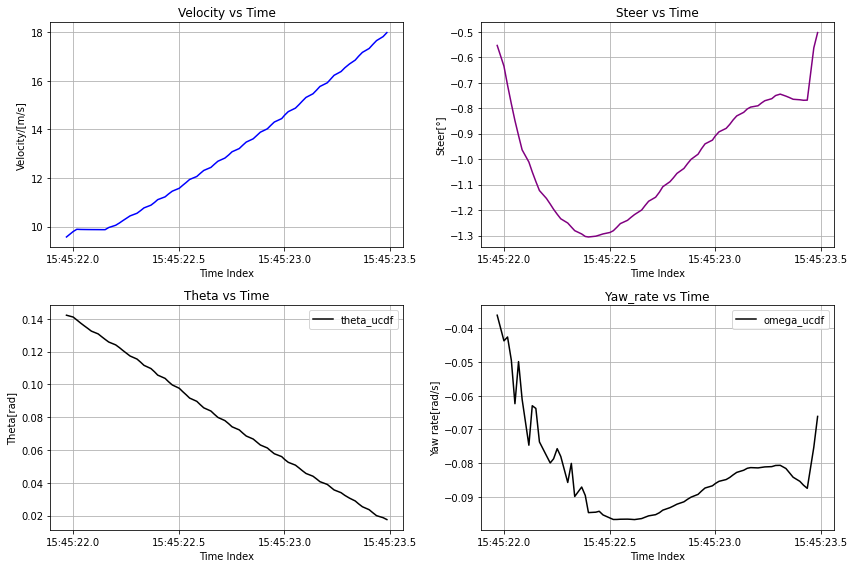

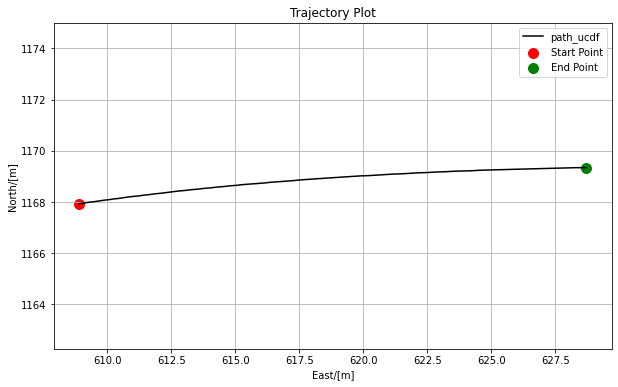

In [97]:
target_turn_idx = 1
continuous_turns = find_continuous_turns(df_log)
target_turn_df_idx = continuous_turns[target_turn_idx]
east = df_log.loc[target_turn_df_idx, 'x'].to_numpy()
north = df_log.loc[target_turn_df_idx, 'y'].to_numpy()
theta = df_log.loc[target_turn_df_idx, 'theta'].to_numpy()
theta = make_angle_sequence_continuous(theta)
yaw_rate = df_log.loc[target_turn_df_idx, 'yaw_rate'].to_numpy()
vel_real = df_log.loc[target_turn_df_idx, 'vx'].to_numpy()
steer_real = df_log.loc[target_turn_df_idx, 'delta'].to_numpy()
time_index = df_log.loc[target_turn_df_idx, 'log_time']
response_log = east, north, theta, yaw_rate, time_index
vehicle_input = vel_real, steer_real
plot_vehicle_traj(response_log, vehicle_input)

# kinematic model simulation

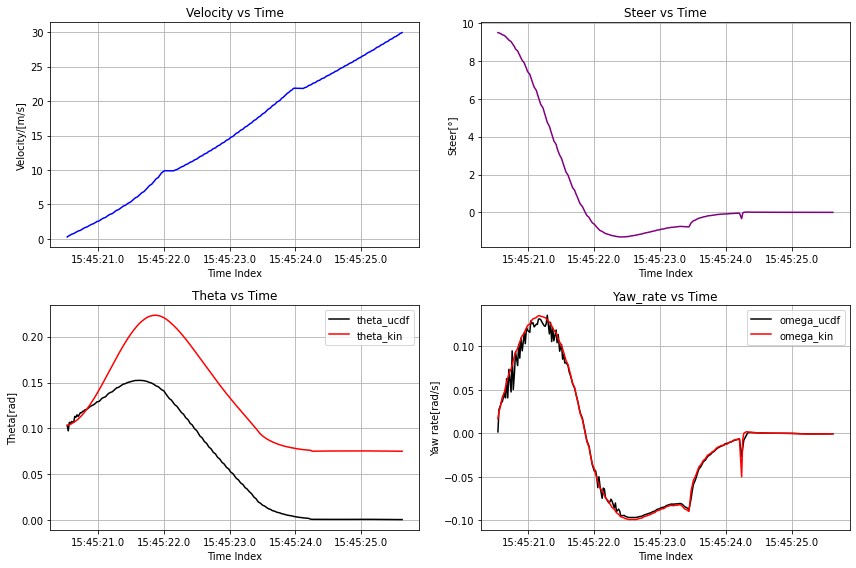

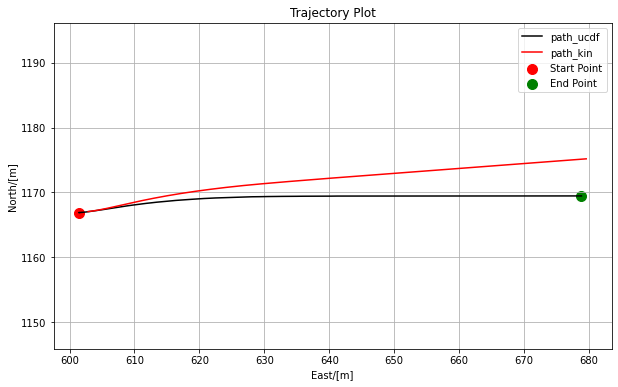

In [98]:
target_turn_df_idx = [i for i in range(60, 300)]
east = df_log.loc[target_turn_df_idx, 'x'].to_numpy()
north = df_log.loc[target_turn_df_idx, 'y'].to_numpy()
theta = df_log.loc[target_turn_df_idx, 'theta'].to_numpy()
theta = make_angle_sequence_continuous(theta)
yaw_rate = df_log.loc[target_turn_df_idx, 'yaw_rate'].to_numpy()
vel_real = df_log.loc[target_turn_df_idx, 'vx'].to_numpy()
steer_real = df_log.loc[target_turn_df_idx, 'delta'].to_numpy()
time_index = df_log.loc[target_turn_df_idx, 'log_time']
response_log = east, north, theta, yaw_rate, time_index
vehicle_input = vel_real, steer_real
# plot_vehicle_traj(response_log, vehicle_input)

steer_real = steer_real / 180.0 * np.pi
time_index = df_log.loc[target_turn_df_idx, 'log_time']
time_diffs = time_index.diff().dt.total_seconds().fillna(0).to_numpy()

# 车辆模型参数
# /ssd/open_source/torcs/torcs-1.3.7/data/cars/models/car1-trb1/car1-trb1.xml
m = 1150 + 94
lf = 1.22
lr = 1.42
l = lf + lr
width = 1.94
length = 4.52
k = 0.62
k = k * k
Iinv_z = 12.0 / (m * (width * width + k * length * length))
Iz = 1.0 / Iinv_z
vehicle = VehicleModel(m, lf, lr, Iz, Cf = 3.0054e+04, Cr = 2.8930e+04, width = width)

# 仿真参数
t = np.cumsum(time_diffs)
v = vel_real
delta = steer_real
# 注意east north theta均为质心的，换算到自车后轴中心
east_rear_axes = np.array(east) - lr * np.cos(theta)
north_rear_axes = np.array(north) - lr * np.sin(theta)
response_log = east_rear_axes, north_rear_axes, theta, yaw_rate, time_index
state = [east[0], north[0], theta[0], 0.0, 0.0]

response_kin = vehicle.kinematics_sim(state, t, v, delta)
X_kin = [r[0] for r in response_kin]
Y_kin = [r[1] for r in response_kin]
theta_kin = [r[2] for r in response_kin]
beta_kin = [r[3] for r in response_kin]
omega_kin = v * np.tan(delta) / vehicle.l
response_kin = X_kin, Y_kin, theta_kin, omega_kin, time_index
steer_real = steer_real / np.pi * 180.0
vehicle_input = vel_real, steer_real
plot_vehicle_traj(response_log, vehicle_input, response_dyn = None, response_kin = response_kin)

# tire model fit

In [99]:
# 定义一个函数将角度转换到 -π 到 π 区间
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

In [100]:
input_file = "/ssd/open_source/torcs/torcs-1.3.7/scr_client/TireOutput.log"
pattern = "index: 0, Slip_Angle_rad: 0.0003817031, Lateral_Force_N: -3.8339279"
log_data, log_time, log_key = parse_data(input_file, pattern)
df_log = pd.DataFrame(log_data, columns=log_key)
df_log.insert(0, 'log_time', log_time)

# 对 Slip_Angle_rad 列应用转换函数
df_log['Slip_Angle_rad'] = df_log['Slip_Angle_rad'].apply(wrap_angle)
df_log

#1 2025-04-05 15:48:27.708 info <wheel.cpp:309> index: 1, Slip_Angle_rad: 0.0031903514, Lateral_

,log_time,index,Slip_Angle_rad,Lateral_Force_N
0,2025-04-05 15:45:18.088,0.0,0.000000,0.00000
1,2025-04-05 15:45:18.088,1.0,0.000000,0.00000
2,2025-04-05 15:45:18.088,2.0,0.000000,0.00000
3,2025-04-05 15:45:18.088,3.0,0.000000,0.00000
4,2025-04-05 15:45:18.088,0.0,0.000000,0.00000
...,...,...,...,...
376836,2025-04-05 15:48:27.708,0.0,0.003195,-458.48530
376837,2025-04-05 15:48:27.708,1.0,0.003190,-464.78980
376838,2025-04-05 15:48:27.708,2.0,0.002611,-408.57437
376839,2025-04-05 15:48:27.708,3.0,0.002607,-413.43182


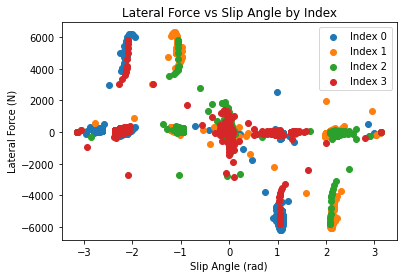

In [102]:
df_log['log_time'] = pd.to_datetime(df_log['log_time'])
time_threshold = pd.to_datetime('2025-04-05 15:45:25.0')
df_log = df_log[df_log['log_time'] < time_threshold]
# 筛选出 index 为 1、2、3、4 的数据
indices = [0, 1, 2, 3]
for idx in indices:
    subset = df_log[df_log['index'] == idx]
    if not subset.empty:
        plt.scatter(subset['Slip_Angle_rad'], subset['Lateral_Force_N'], label=f'Index {idx}')

# 设置图表标题和坐标轴标签
plt.title('Lateral Force vs Slip Angle by Index')
plt.xlabel('Slip Angle (rad)')
plt.ylabel('Lateral Force (N)')

# 显示图例
plt.legend()

# 显示图表
plt.show()

In [ ]:
#define FRNT_RGT	0	/**< front right */
#define FRNT_LFT	1	/**< front left */
#define REAR_RGT	2	/**< rear right */
#define REAR_LFT	3	/**< rear left */

# params identidy

In [ ]:
def sse_loss(y_real, y_pre):
    return np.sum(np.power(y_real - y_pre, 2))

def mae_loss(y_real, y_pre):
    return np.mean(np.abs(y_real - y_pre))

def params_to_loss(params):
    Cf = params[0]
    Cr = params[1]

    m = 1150 + 94
    lf = 1.22
    lr = 1.42
    l = lf + lr
    width = 1.94
    length = 4.52
    k = 0.62
    k = k * k
    Iinv_z = 12.0 / (m * (width * width + k * length * length))
    Iz = 1.0 / Iinv_z
    vehicle = VehicleModel(m, lf, lr, Iz, Cf = Cf, Cr = Cr, width = width)

    loss = 0.0
    # for target_turn_idx in range(len(continuous_turns)):
    for target_turn_idx in range(1):
        target_turn_df_idx = continuous_turns[target_turn_idx]
        east = df_log.loc[target_turn_df_idx, 'x'].to_numpy()
        north = df_log.loc[target_turn_df_idx, 'y'].to_numpy()
        theta = df_log.loc[target_turn_df_idx, 'theta'].to_numpy()
        theta = make_angle_sequence_continuous(theta)
        yaw_rate = df_log.loc[target_turn_df_idx, 'yaw_rate'].to_numpy()
        vel_lon = df_log.loc[target_turn_df_idx, 'vx'].to_numpy()
        vel_lateral = df_log.loc[target_turn_df_idx, 'vy'].to_numpy()
        steer_real = df_log.loc[target_turn_df_idx, 'delta'].to_numpy()
        steer_real = steer_real / 180.0 * np.pi
        time_index = df_log.loc[target_turn_df_idx, 'log_time']
        time_diffs = time_index.diff().dt.total_seconds().fillna(0).to_numpy()

        # 仿真参数
        t = np.cumsum(time_diffs)
        v = vel_lon
        delta = steer_real
        state = [east[0], north[0], theta[0], 0.0, 0.0]

        response_dyn = vehicle.dynamics_sim(state, t, v, delta)
        X = [r[0] for r in response_dyn]
        Y = [r[1] for r in response_dyn]
        Theta = [r[2] for r in response_dyn]
        Beta = [r[3] for r in response_dyn]
        Omega = [r[4] for r in response_dyn]
        Vy = [vel * np.tan(beta) for vel, beta in zip(vel_lon, Beta)]

        # loss += sse_loss(east, X) + sse_loss(north, Y) + sse_loss(theta, Theta) + sse_loss(yaw_rate, Omega)
        ucdf_path = np.column_stack((east, north))
        dyna_path = np.array([X, Y]).T
        # discrete_frechet_distance = similaritymeasures.frechet_dist(ucdf_path, dyna_path)
        # loss += discrete_frechet_distance + sse_loss(vel_lateral, Vy) + sse_loss(yaw_rate, Omega)
        # loss += sse_loss(vel_lateral, Vy) + sse_loss(yaw_rate, Omega)
        loss += sse_loss(yaw_rate, Omega)

    return loss

x0 = (3.0e4, 3.0e4)
params_to_loss(x0)

In [ ]:
np.seterr(divide='ignore', invalid='ignore')
minimum = optimize.minimize(params_to_loss, x0 = (3.0e4, 3.0e4), bounds = ([2.0e4, 20.0e4], [2.0e4, 20.0e4]))
minimum

In [ ]:
algorithm_param = {'max_num_iteration': 100,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}
obj = params_to_loss
varbound = np.array([[2e4, 20.0e4], [2e4, 20.0e4]])
model = ga(function = obj,
           dimension = 2,
           variable_type = 'real',
           variable_boundaries = varbound,
           algorithm_parameters = algorithm_param)
model.run()

In [ ]:
target_turn_df_idx = [i for i in range(60, 300)]
east = df_log.loc[target_turn_df_idx, 'x'].to_numpy()
north = df_log.loc[target_turn_df_idx, 'y'].to_numpy()
theta = df_log.loc[target_turn_df_idx, 'theta'].to_numpy()
theta = make_angle_sequence_continuous(theta)
yaw_rate = df_log.loc[target_turn_df_idx, 'yaw_rate'].to_numpy()
vel_real = df_log.loc[target_turn_df_idx, 'vx'].to_numpy()
steer_real = df_log.loc[target_turn_df_idx, 'delta'].to_numpy()
time_index = df_log.loc[target_turn_df_idx, 'log_time']
response_log = east, north, theta, yaw_rate, time_index
vehicle_input = vel_real, steer_real
# plot_vehicle_traj(response_log, vehicle_input)

steer_real = steer_real / 180.0 * np.pi
time_index = df_log.loc[target_turn_df_idx, 'log_time']
time_diffs = time_index.diff().dt.total_seconds().fillna(0).to_numpy()

t = np.cumsum(time_diffs)
v = vel_real
delta = steer_real

Cf, Cr = model.output_dict['variable'][0], model.output_dict['variable'][1]
vehicle = VehicleModel(m, lf, lr, Iz, Cf = Cf, Cr = Cr, width = width)
response_dyn = vehicle.dynamics_sim(state, t, v, delta)
X = [r[0] for r in response_dyn]
Y = [r[1] for r in response_dyn]
Theta = [r[2] for r in response_dyn]
Beta = [r[3] for r in response_dyn]
Omega = [r[4] for r in response_dyn]
response_dyn = X, Y, Theta, Omega, time_index
response_log = east, north, theta, yaw_rate, time_index
plot_vehicle_traj(response_log, vehicle_input, response_dyn = response_dyn)